In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from src.leachSFtree import leachSFClusteringJoin, leachSFClusteringTreeJoin
from src.mst_prim import prim_mst, create_routes_dict
import src.util as util
import src.topology as topology
import networkx as nx
from src.nova_join import Operator, OperatorType, NovaSolver
from src.util import log_opt_label, coordinator_label, worker_label, centroid_label, ch_label, join_label, source_label, \
    euclidean_distance
from src.cardinalities import create_cardinalities, create_adjacency_matrix, create_unique_n_tuples, \
    create_adjacency_matrix_from_pairs, generate_random_integer_dict
from src.util import evaluate_graph, evaluate_routes, plot_distributions_pdf, add_arrow_label
from src.topology import transition_uniform_to_exponential, create_topologies_from_dict
from src.baselines import sink_based_placement, source_based_placement, top_c
from src.eval_tools import *
import math
from scipy.spatial.distance import cdist
from tabulate import tabulate

### Topology Embedding

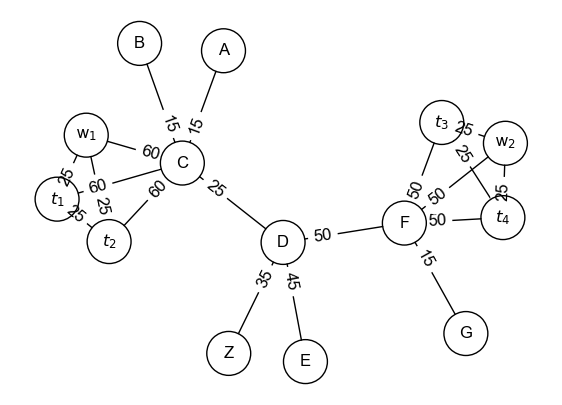

In [2]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
font_size_plot = 12

# Create a graph
topology_graph = nx.Graph()
topology_graph.add_edge(r"$t_{1}$", "C", weight=60)
topology_graph.add_edge(r"$t_{2}$", "C", weight=60)
topology_graph.add_edge(r"w$_{1}$", "C", weight=60)
topology_graph.add_edge("C", "A", weight=15)
topology_graph.add_edge("C", "B", weight=15)
topology_graph.add_edge("C", "D", weight=25)
topology_graph.add_edge("D", "E", weight=45)
topology_graph.add_edge("D", "Z", weight=35)
topology_graph.add_edge("D", "F", weight=50)
topology_graph.add_edge("F", "G", weight=15)
topology_graph.add_edge(r"$t_{3}$", "F", weight=50)
topology_graph.add_edge(r"$t_{4}$", "F", weight=50)
topology_graph.add_edge(r"w$_{2}$", "F", weight=50)

topology_graph.add_edge(r"$t_{1}$", r"$t_{2}$", weight=25)
topology_graph.add_edge(r"$t_{1}$", r"w$_{1}$", weight=25)
topology_graph.add_edge(r"$t_{2}$", r"w$_{1}$", weight=25)

topology_graph.add_edge(r"$t_{3}$", r"w$_{2}$", weight=25)
topology_graph.add_edge(r"$t_{3}$", r"$t_{4}$", weight=25)
topology_graph.add_edge(r"$t_{4}$", r"w$_{2}$", weight=25)


# Draw the graph
pos = nx.nx_agraph.graphviz_layout(topology_graph, prog='neato')
nx.draw(topology_graph, pos, ax=ax1, with_labels=True, arrows=True, node_color='none', edgecolors='black',
        node_size=1000)

# Extract the labels from node attributes
labels = nx.get_node_attributes(topology_graph, 'type')
nx.draw_networkx_labels(topology_graph, pos, labels, font_size=font_size_plot)

# Extract and draw edge labels
edge_labels = nx.get_edge_attributes(topology_graph, 'weight')  # Use the 'weight' attribute as edge labels
nx.draw_networkx_edge_labels(topology_graph, pos, edge_labels=edge_labels, font_size=font_size_plot, ax=ax1,
                             label_pos=0.3)

# Show the plot
#plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_logical_plan_{source_frac}.svg", bbox_inches="tight", format="svg")
plt.show()

In [3]:
# Get list of nodes
nodes = list(topology_graph.nodes())
n = len(nodes)

# Create an empty matrix
latency_matrix = np.zeros((n, n))

# Compute shortest paths
for i, src in enumerate(nodes):
    for j, dst in enumerate(nodes):
        if i != j:
            try:
                latency_matrix[i, j] = nx.shortest_path_length(topology_graph, source=src, target=dst, weight="weight")
            except nx.NetworkXNoPath:
                latency_matrix[i, j] = np.inf  # No path available

# Convert to Pandas DataFrame for better visualization
df = pd.DataFrame(latency_matrix, index=nodes, columns=nodes)
df

,$t_{1}$,C,$t_{2}$,w$_{1}$,A,B,D,E,Z,F,G,$t_{3}$,$t_{4}$,w$_{2}$
$t_{1}$,0.0,60.0,25.0,25.0,75.0,75.0,85.0,130.0,120.0,135.0,150.0,185.0,185.0,185.0
C,60.0,0.0,60.0,60.0,15.0,15.0,25.0,70.0,60.0,75.0,90.0,125.0,125.0,125.0
$t_{2}$,25.0,60.0,0.0,25.0,75.0,75.0,85.0,130.0,120.0,135.0,150.0,185.0,185.0,185.0
w$_{1}$,25.0,60.0,25.0,0.0,75.0,75.0,85.0,130.0,120.0,135.0,150.0,185.0,185.0,185.0
A,75.0,15.0,75.0,75.0,0.0,30.0,40.0,85.0,75.0,90.0,105.0,140.0,140.0,140.0
B,75.0,15.0,75.0,75.0,30.0,0.0,40.0,85.0,75.0,90.0,105.0,140.0,140.0,140.0
D,85.0,25.0,85.0,85.0,40.0,40.0,0.0,45.0,35.0,50.0,65.0,100.0,100.0,100.0
E,130.0,70.0,130.0,130.0,85.0,85.0,45.0,0.0,80.0,95.0,110.0,145.0,145.0,145.0
Z,120.0,60.0,120.0,120.0,75.0,75.0,35.0,80.0,0.0,85.0,100.0,135.0,135.0,135.0
F,135.0,75.0,135.0,135.0,90.0,90.0,50.0,95.0,85.0,0.0,15.0,50.0,50.0,50.0


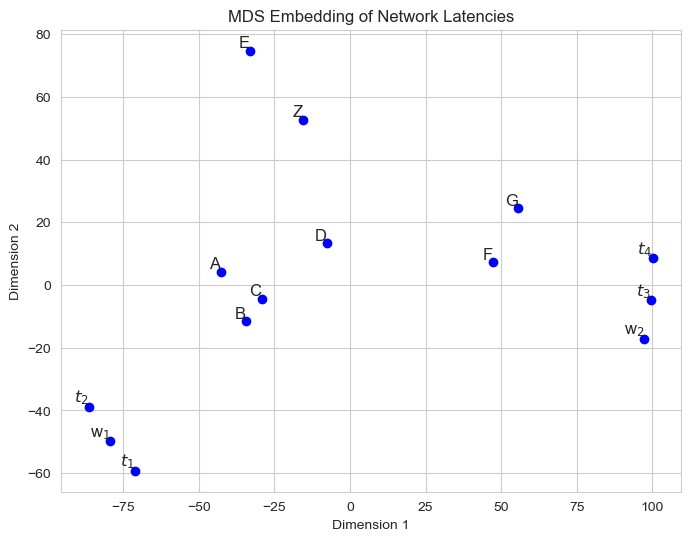

In [4]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

embedding_idx_map = {
    'Z': 0,
    r"$t_{1}$": 1, r"$t_{2}$": 2, r"$t_{3}$": 3, r"$t_{4}$": 4, r"w$_{1}$": 5, r"w$_{2}$": 6,
    'A': 7, 'B': 8, 'C': 9, 'D': 10, 'E': 11, 'F': 12, 'G': 13
}

# Convert the DataFrame to a NumPy array (if not already)
dist_matrix = df.to_numpy()

# Apply MDS to embed the points in 2D space
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=24, max_iter=3000, eps=1e-9)
embedding = mds.fit_transform(dist_matrix)

# Convert to DataFrame for clarity
embedding_df = pd.DataFrame(embedding, index=df.index, columns=["x", "y"])
embedding_df["latency"] = 0
for idx in embedding_df.index:
    embedding_df.loc[idx, "latency"] = df.loc[idx, "Z"]

# Plot the embedding
plt.figure(figsize=(8, 6))
plt.scatter(embedding_df["x"], embedding_df["y"], color="blue")

# Annotate points with node labels
for node, (x, y, l) in embedding_df.iterrows():
    plt.text(x, y, str(node), fontsize=12, ha='right', va='bottom')

plt.title("MDS Embedding of Network Latencies")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [5]:
embedding_df

,x,y,latency
$t_{1}$,-71.238546,-59.213372,120
C,-29.237516,-4.326080,60
$t_{2}$,-86.271612,-38.832366,120
w$_{1}$,-79.251077,-49.886411,120
A,-42.780357,4.293469,75
B,-34.323376,-11.423652,75
D,-7.568528,13.443450,35
E,-33.087574,74.692716,80
Z,-15.663157,52.740314,0
F,47.241869,7.321933,85


In [6]:
embedding_idx_map

{'Z': 0,
 '$t_{1}$': 1,
 '$t_{2}$': 2,
 '$t_{3}$': 3,
 '$t_{4}$': 4,
 'w$_{1}$': 5,
 'w$_{2}$': 6,
 'A': 7,
 'B': 8,
 'C': 9,
 'D': 10,
 'E': 11,
 'F': 12,
 'G': 13}

## Topology

In [7]:
types = {
    'Z': "SINK",
    r"$t_{1}$": "SOURCE", r"$t_{2}$": "SOURCE", r"$t_{3}$": "SOURCE", r"$t_{4}$": "SOURCE", r"w$_{1}$": "SOURCE", r"w$_{2}$": "SOURCE",
    'A': "WORKER", 'B': "WORKER", 'C': "WORKER", 'D': "WORKER", 'E': "WORKER", 'F': "WORKER", 'G': "WORKER"
}

capacities = {
    'Z': 20,
    r"$t_{1}$": 10, r"$t_{2}$": 10, r"$t_{3}$": 10, r"$t_{4}$": 10, r"w$_{1}$": 10, r"w$_{2}$": 10,
    'A': 55, 'B': 40, 'C': 40, 'D': 20, 'E': 2000, 'F': 20, 'G': 200
}

clustering = False
source_frac = round(list(types.values()).count("SOURCE") / len(types), 2)

# Reset index to turn it into a column
latency_df = embedding_df.copy()
latency_df = latency_df.reset_index()

# Rename the 'index' column to 'Old Index'
latency_df = latency_df.rename(columns={"index": "label"})

# Apply the mapping to rename the old index in the matrix
latency_df["New Index"] = latency_df["label"].map(embedding_idx_map)

# Reindex the DataFrame based on the sorted order of new indices
latency_df = latency_df.set_index("New Index").reindex(sorted(embedding_idx_map.values()))
latency_df["cluster"] = 0
latency_df["type"] = latency_df["label"].map(types).astype("category")

latency_df["weight"] = 0  # Default to 0
latency_df.loc[latency_df["type"] == "SOURCE", "weight"] = 25

latency_df["capacity"] = latency_df["label"].map(capacities)

# Remove the index name
latency_df.index.name = None
prim_df = latency_df.copy()

print("source fraction:", source_frac)
prim_df

source fraction: 0.43


,label,x,y,latency,cluster,type,weight,capacity
0,Z,-15.663157,52.740314,0,0,SINK,0,20
1,$t_{1}$,-71.238546,-59.213372,120,0,SOURCE,25,10
2,$t_{2}$,-86.271612,-38.832366,120,0,SOURCE,25,10
3,$t_{3}$,99.410200,-4.819343,135,0,SOURCE,25,10
4,$t_{4}$,100.082176,8.597689,135,0,SOURCE,25,10
5,w$_{1}$,-79.251077,-49.886411,120,0,SOURCE,25,10
6,w$_{2}$,97.199757,-17.064994,135,0,SOURCE,25,10
7,A,-42.780357,4.293469,75,0,WORKER,0,55
8,B,-34.323376,-11.423652,75,0,WORKER,0,40
9,C,-29.237516,-4.326080,60,0,WORKER,0,40


In [8]:
seed = 10

device_number = prim_df.shape[0]
coord_cols = ["x", "y"]
eval_columns = ["capacity"]

# plotting params
font_size_plot = 15
font_size_legend = 12
scale_fac_plot = 1.2
lw = 2

eval_matrix = {}

In [9]:
colors, colors_hex, light_colors = util.get_color_list(10 + 1)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

## Topology Plot

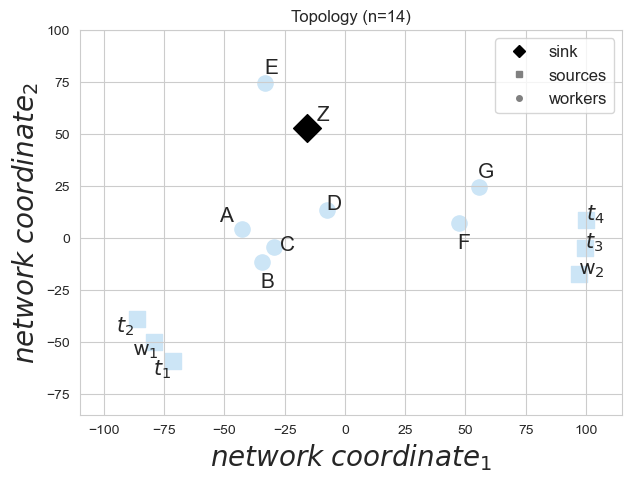

In [10]:
def get_label_pos(s_label, x, y):
    if s_label in [r"$T_{11}$", r"$T_{12}$"]:
        x = x - 3.5
        y = y + 3.5
    elif s_label in ["B", "F"]:
        x = x - 0.5
        y = y - 12.5
    elif s_label in ["C"]:
        x = x + 2.5
        y = y - 1.5
    elif s_label in ["A"]:
        x = x - 9.5
        y = y + 3.5
    elif s_label in ["C", "G", "E"]:
        x = x - 0.5
        y = y + 4.5
    elif s_label in [r"$t_{1}$", r"$t_{2}$", r"w$_{1}$"]:
        x = x - 8.5
        y = y - 6.5
    elif s_label == "Z":
        x = x + 4
        y = y + 3.5
    return x, y

X_dim_plot = [-110, 115]
Y_dim_plot = [-85, 100]

fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, colors=colors, scale_fac=scale_fac_plot,
                         plot_voronoi=False, plot_centroid=False)

# Add labels next to each point
for i in range(0, prim_df.shape[0]):
    x, y = prim_df.loc[i, coord_cols].to_numpy()
    s_label = prim_df.loc[i, "label"]
    x, y = get_label_pos(s_label, x, y)
    ax1.text(x, y, s_label, fontsize=font_size_plot, ha='left')

ax1.set_xlim(X_dim_plot)
ax1.set_ylim(Y_dim_plot)

# Create a custom handle for the double-ended arrow line
handles = [coordinator_label, source_label, worker_label]
ax1.legend(handles=handles, loc="upper right", prop={'size': font_size_legend})

plt.savefig("plots/sim/sim_{0}/sim_{0}_ncs.svg".format(str(device_number)), bbox_inches="tight")
plt.title(f"Topology (n={device_number})")
plt.show()

### Create Join Matrix

In [11]:
sink_capacity = prim_df.loc[0, "capacity"]
output_range = [3, 10]

join_pair_labels = [(r"w$_{1}$", r"$t_{1}$"), (r"w$_{1}$", r"$t_{2}$"),
                    (r"w$_{2}$", r"$t_{3}$"), (r"w$_{2}$", r"$t_{4}$")]
join_pairs = []
for a, b in join_pair_labels:
    join_pairs.append((embedding_idx_map[a], embedding_idx_map[b]))

join_matrix_df, join_matrix, required = create_adjacency_matrix_from_pairs(prim_df.shape[0], join_pairs, output_range, output_sum=sink_capacity-5, seed=seed)
print(f"Required resources for sinks:{required}")
join_matrix_df.head(10)

Generating n=4 random integers between 3 and 10, sum=15
Required resources for sinks:15


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,3,0,0,0,0,0,0,0,0
2,0,0,0,0,0,5,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,4,0,0,0,0,0,0,0
4,0,0,0,0,0,0,3,0,0,0,0,0,0,0
5,0,3,5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,4,3,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
prim_df

,label,x,y,latency,cluster,type,weight,capacity
0,Z,-15.663157,52.740314,0,0,SINK,0,20
1,$t_{1}$,-71.238546,-59.213372,120,0,SOURCE,25,10
2,$t_{2}$,-86.271612,-38.832366,120,0,SOURCE,25,10
3,$t_{3}$,99.410200,-4.819343,135,0,SOURCE,25,10
4,$t_{4}$,100.082176,8.597689,135,0,SOURCE,25,10
5,w$_{1}$,-79.251077,-49.886411,120,0,SOURCE,25,10
6,w$_{2}$,97.199757,-17.064994,135,0,SOURCE,25,10
7,A,-42.780357,4.293469,75,0,WORKER,0,55
8,B,-34.323376,-11.423652,75,0,WORKER,0,40
9,C,-29.237516,-4.326080,60,0,WORKER,0,40


## Network Latencies

In [13]:
table_labels = prim_df["label"].tolist()

# set coordinates
coordinates = list(zip(prim_df['x'], prim_df['y']))
coords_array = np.array(coordinates)
# set the capacities
capacities = prim_df["capacity"]

# Calculate the pairwise Euclidean distance matrix
distance_matrix = cdist(coords_array, coords_array, metric='euclidean')
distance_matrix_with_capacities = np.column_stack([distance_matrix, capacities])

print(tabulate(distance_matrix_with_capacities, tablefmt="latex", floatfmt=".0f", showindex=True,
               headers=table_labels + ["Capacity"]))

\begin{tabular}{rrrrrrrrrrrrrrrr}
\hline
    &   Z &   \$t\_\{1\}\$ &   \$t\_\{2\}\$ &   \$t\_\{3\}\$ &   \$t\_\{4\}\$ &   w\$\_\{1\}\$ &   w\$\_\{2\}\$ &   A &   B &   C &   D &   E &   F &   G &   Capacity \\
\hline
  0 &   0 &       125 &       116 &       129 &       124 &       121 &       133 &  56 &  67 &  59 &  40 &  28 &  78 &  77 &         20 \\
  1 & 125 &         0 &        25 &       179 &       184 &        12 &       174 &  70 &  60 &  69 &  97 & 139 & 136 & 152 &         10 \\
  2 & 116 &        25 &         0 &       189 &       192 &        13 &       185 &  61 &  59 &  67 &  94 & 125 & 141 & 155 &         10 \\
  3 & 129 &       179 &       189 &         0 &        13 &       184 &        12 & 142 & 134 & 129 & 109 & 155 &  54 &  53 &         10 \\
  4 & 124 &       184 &       192 &        13 &         0 &       189 &        26 & 143 & 136 & 130 & 108 & 149 &  53 &  47 &         10 \\
  5 & 121 &        12 &        13 &       184 &       189 &         0 &       179 

## Topology with Nodes and Join

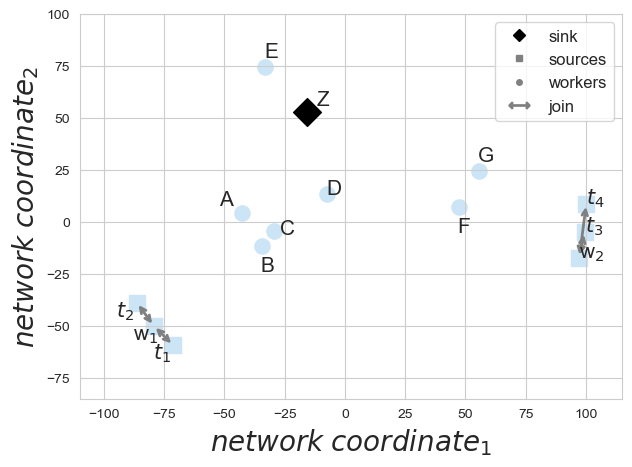

In [14]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, scale_fac=scale_fac_plot,
                             plot_voronoi=True, plot_centroid=False)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, scale_fac=scale_fac_plot,
                             plot_voronoi=False, plot_centroid=False)

for i, j in join_pairs:
    if join_matrix[i, j] > 0:
        point1 = prim_df.iloc[i][coord_cols].to_numpy()
        point2 = prim_df.iloc[j][coord_cols].to_numpy()
        cluster = prim_df.loc[i, "cluster"]
        # print(i, j, point1, point2)
        arrow = FancyArrowPatch(point1, point2, arrowstyle='<->', mutation_scale=10, color="grey", linewidth=lw)
        ax1.add_patch(arrow)

# Add labels next to each point
for i in range(0, prim_df.shape[0]):
    x, y = prim_df.loc[i, coord_cols].to_numpy()
    s_label = prim_df.loc[i, "label"]
    x, y = get_label_pos(s_label, x, y)
    ax1.text(x, y, s_label, fontsize=font_size_plot, ha='left')

ax1.set_xlim(X_dim_plot)
ax1.set_ylim(Y_dim_plot)

# Create a custom handle for the double-ended arrow line
handles = [coordinator_label, source_label, worker_label, join_label]
ax1.legend(handles=handles, loc="upper right", prop={'size': font_size_legend})

plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_ncs_grouped_{source_frac}.svg", bbox_inches="tight")

#ax1.set_title(f"Topology (n={device_number})")
plt.show()

### Logical Plans Visualization

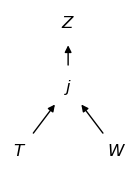

In [15]:
fig, (ax1) = plt.subplots(1, 1, figsize=(1.5, 2))

# Create a graph
logical_plan = nx.DiGraph()

# Add nodes with labels as attributes
logical_plan.add_node(1, type=r"$T$")
logical_plan.add_node(2, type=r"$W$")
logical_plan.add_node(3, type=r"$j$")
logical_plan.add_node(4, type=r"$Z$")

# Add edges between nodes
logical_plan.add_weighted_edges_from([(1, 3, 1), (2, 3, 1), (3, 4, 1)])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan, prog="dot", args="-Grankdir=BT")
nx.draw(logical_plan, pos, ax=ax1, with_labels=False, arrows=True, node_color='none', node_size=1000)

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan, 'type')

# Draw the labels on the graph
nx.draw_networkx_labels(logical_plan, pos, labels)

plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_query_plan_{source_frac}_plain.svg", bbox_inches="tight",
            format="svg")
# Show the plot
plt.show()

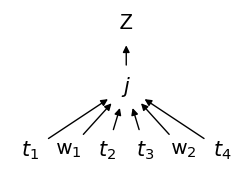

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(3, 2))

# Create a graph
logical_plan_plot = nx.DiGraph()

# Add nodes with labels as attributes
i = 1
j = 1
join_nodes = []
logical_plan_plot.add_node(0, type="Z")
logical_plan_plot.add_node(100, type=fr"$j$")
logical_plan_plot.add_edge(100, 0)
unresolved_join_pairs = [r"$t_1$", r"w$_1$", r"$t_2$", r"$t_3$", r"w$_2$", r"$t_4$"]

for a in unresolved_join_pairs:
    # add nodes
    logical_plan_plot.add_node(i, type=a)
    # add edges
    logical_plan_plot.add_edge(i, 100)
    i += 1

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan_plot, prog="dot", args="-Grankdir=BT")

nx.draw(logical_plan_plot, pos, ax=ax1, with_labels=False, arrows=True, node_color='none', #edgecolors='black',
        node_size=1000)

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan_plot, 'type')
nx.draw_networkx_labels(logical_plan_plot, pos, labels, font_size=font_size_plot)

# Extract and draw edge labels
edge_labels = nx.get_edge_attributes(logical_plan_plot, 'weight')  # Use the 'weight' attribute as edge labels
#nx.draw_networkx_edge_labels(logical_plan_plot, pos, edge_labels=edge_labels, font_size=font_size_plot, ax=ax1,
#                             label_pos=0.3)

# Show the plot
plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_logical_plan_res_sources_{source_frac}_plain.svg", bbox_inches="tight",
            format="svg")
plt.show()

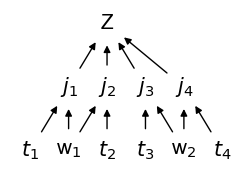

In [17]:
fig, (ax1) = plt.subplots(1, 1, figsize=(3, 2))

# Create a graph
logical_plan_plot = nx.DiGraph()

# Add nodes with labels as attributes
j = 1
join_nodes = []
jp = [(r"w$_{1}$", r"$t_{2}$"), (r"w$_{1}$", r"$t_{1}$"),
      (r"w$_{2}$", r"$t_{3}$"), (r"w$_{2}$", r"$t_{4}$")]

for a, b in jp:
    a_index = prim_df.index[prim_df['label'] == a][0]
    b_index = prim_df.index[prim_df['label'] == b][0]

    # add nodes
    logical_plan_plot.add_node(a_index, type=a)
    logical_plan_plot.add_node(b_index, type=b)
    if b == r"$t_{2}$":
        join_type = fr"$j_2$"
    elif b == r"$t_{1}$":
        join_type = fr"$j_1$"
    else:
        join_type = fr"$j_{j}$"
    logical_plan_plot.add_node(100 + j, type=join_type)
    # add edges
    logical_plan_plot.add_edge(a_index, 100 + j, weight=prim_df.loc[a_index, "weight"])
    logical_plan_plot.add_edge(b_index, 100 + j, weight=prim_df.loc[b_index, "weight"])
    join_nodes.append((100 + j, (a_index, b_index)))
    j += 1

logical_plan_plot.add_node(0, type="Z")
for join_node, pairs in join_nodes:
    logical_plan_plot.add_edge(join_node, 0, weight=join_matrix[*pairs])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan_plot, prog="dot", args="-Grankdir=BT")
nx.draw(logical_plan_plot, pos, ax=ax1, with_labels=False, arrows=True, node_color='none', #edgecolors='black',
        node_size=1000)

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan_plot, 'type')
nx.draw_networkx_labels(logical_plan_plot, pos, labels, font_size=font_size_plot)

# Extract and draw edge labels
edge_labels = nx.get_edge_attributes(logical_plan_plot, 'weight')  # Use the 'weight' attribute as edge labels
#nx.draw_networkx_edge_labels(logical_plan_plot, pos, edge_labels=edge_labels, font_size=font_size_plot, ax=ax1,
#                             label_pos=0.3)

# Show the plot
plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_logical_plan_res_join_{source_frac}_plain.svg", bbox_inches="tight",
            format="svg")
plt.show()

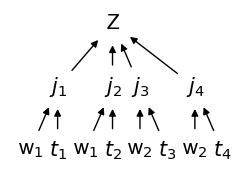

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(3, 2))

# Create a graph
logical_plan_plot = nx.DiGraph()

# Add nodes with labels as attributes
i = 1
j = 1
join_nodes = []
for a, b in join_pair_labels:
    # add nodes
    logical_plan_plot.add_node(i, type=a)
    logical_plan_plot.add_node(i + 1, type=b)
    logical_plan_plot.add_node(100 + j, type=fr"$j_{j}$")
    # add edges
    a_index = prim_df.index[prim_df['label'] == a][0]
    b_index = prim_df.index[prim_df['label'] == b][0]
    logical_plan_plot.add_edge(i, 100 + j, weight=prim_df.loc[a_index, "weight"])
    logical_plan_plot.add_edge(i + 1, 100 + j, weight=prim_df.loc[b_index, "weight"])
    join_nodes.append((100 + j, (a_index, b_index)))
    i += 2
    j += 1

logical_plan_plot.add_node(0, type="Z")
for join_node, pairs in join_nodes:
    logical_plan_plot.add_edge(join_node, 0, weight=join_matrix[*pairs])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan_plot, prog="dot", args="-Grankdir=BT")
nx.draw(logical_plan_plot, pos, ax=ax1, with_labels=False, arrows=True, node_color='none', #edgecolors='black',
        node_size=1000)

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan_plot, 'type')
nx.draw_networkx_labels(logical_plan_plot, pos, labels, font_size=font_size_plot)

# Extract and draw edge labels
edge_labels = nx.get_edge_attributes(logical_plan_plot, 'weight')  # Use the 'weight' attribute as edge labels
#nx.draw_networkx_edge_labels(logical_plan_plot, pos, edge_labels=edge_labels, font_size=font_size_plot, ax=ax1,
#                             label_pos=0.3)

# Show the plot
plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_logical_plan_res_all_resolved_{source_frac}_plain.svg", bbox_inches="tight",
            format="svg")
plt.show()

## Nova Input Plan

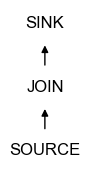

In [19]:
fig, (ax1) = plt.subplots(1, 1, figsize=(0.9, 2))

# Create a graph
logical_plan = nx.DiGraph()

# Add nodes with labels as attributes
logical_plan.add_node(1, type=OperatorType.SOURCE)
logical_plan.add_node(2, type=OperatorType.JOIN)
logical_plan.add_node(3, type=OperatorType.SINK)

# Add edges between nodes
logical_plan.add_weighted_edges_from([(1, 2, 1), (2, 3, 1)])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan, prog="dot", args="-Grankdir=BT")
nx.draw(logical_plan, pos, ax=ax1, with_labels=False, arrows=True, node_color='none', node_size=1000)

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan, 'type')

# Draw the labels on the graph
nx.draw_networkx_labels(logical_plan, pos, labels)

# Show the plot
plt.show()

## Perform Placement

### Nova

In [20]:
reduction_fac = 0.4
source_rates = prim_df[prim_df["weight"] > 0]["weight"].to_dict()
cardinality_dict = {1: source_rates, 2: (join_matrix, join_pairs)}

df_stats = None
nova_placements = {}

In [21]:
prim_df

,label,x,y,latency,cluster,type,weight,capacity
0,Z,-15.663157,52.740314,0,0,SINK,0,20
1,$t_{1}$,-71.238546,-59.213372,120,0,SOURCE,25,10
2,$t_{2}$,-86.271612,-38.832366,120,0,SOURCE,25,10
3,$t_{3}$,99.410200,-4.819343,135,0,SOURCE,25,10
4,$t_{4}$,100.082176,8.597689,135,0,SOURCE,25,10
5,w$_{1}$,-79.251077,-49.886411,120,0,SOURCE,25,10
6,w$_{2}$,97.199757,-17.064994,135,0,SOURCE,25,10
7,A,-42.780357,4.293469,75,0,WORKER,0,55
8,B,-34.323376,-11.423652,75,0,WORKER,0,40
9,C,-29.237516,-4.326080,60,0,WORKER,0,40


In [90]:
for capacity_col in eval_columns:
    print("Starting nova placement for", capacity_col)
    pdf = prim_df.copy()
    k_resources = 15  #prim_df[capacity_col].quantile(0.1)
    nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=0,
                      knn_neighbors=2, #knn_radius=50, cluster_col="cluster",
                      capacity_col=capacity_col, use_weight=False, pre_knn=False, k_resources=k_resources)
    df_nova_it, rep_plan_it, rel_positions_it, placement_it = nova.nova_full()

    nova_placements[capacity_col] = df_nova_it, rep_plan_it, rel_positions_it, placement_it
    df_stats_it = evaluate_graph(df_nova_it, rep_plan_it)
    eval_matrix["nova_" + capacity_col] = df_stats_it.copy()

Starting nova placement for capacity
Initializing Nova for 14
Running Nova on capacity
Resolving pinned operators
Resolving join operators
Preparing nodes and edges
Initializing coordinates
Computing relaxed positions for n=11 nodes
Relaxed positions: 11
Replicas for 1:6
Replication count for upstream operators to 1 -> 0
Replicas for 2:4
Distributing load: operator_id=15, opt=[-55.22044406960679, -18.50260148499679], upstream_nodes=([5, 1])
Left=25, right=25, batches=625, batch_factor=0, batch_threshold=1, required=1250, part_req=2 resource_limit=15, neighbor_size=2
Searching knn [-55.22044406960679, -18.50260148499679] 7 2 2 0
Distributing finished: operator_id=15 (5, 1) to n=1, opt=[-55.22044406960679, -18.50260148499679], upstream_nodes=[7], additional load=0.0
Distributing load: operator_id=16, opt=[-60.20379747458502, -11.728211921183117], upstream_nodes=([5, 2])
Left=25, right=25, batches=625, batch_factor=0, batch_threshold=1, required=1250, part_req=2 resource_limit=15, neighbo

In [91]:
for k, vals in nova_placements.items():
    df_nova, rep_plan_nova, rel_positions_nova, placement_nova = vals
    if df_nova[df_nova["free_capacity"] < 0].shape[0] > 0:
        print(f"Overloaded: {k}->{df_nova[df_nova['free_capacity'] < 0].shape[0]}")

In [92]:
plot_col = eval_columns[0]
df_nova, rep_plan_nova, rel_positions_nova, placement_nova = nova_placements[plot_col]

In [93]:
placement_nova

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 19: 7, 20: 8, 21: 9, 22: 13, 23: 13, 0: 0}

In [94]:
df_nova.head(10)

,x,y,type,unbalanced,weight,real_weight,total_capacity,free_capacity,level,parent
0,-15.663157,52.740314,SINK,0,0,0,20,5.0,2,[]
1,-71.238546,-59.213372,SOURCE,0,25,25,10,10.0,0,"[(7, 25)]"
2,-86.271612,-38.832366,SOURCE,0,25,50,10,10.0,0,"[(8, 25), (9, 25)]"
3,99.410200,-4.819343,SOURCE,0,25,25,10,10.0,0,"[(13, 25)]"
4,100.082176,8.597689,SOURCE,0,25,25,10,10.0,0,"[(13, 25)]"
5,-79.251077,-49.886411,SOURCE,0,25,50,10,10.0,0,"[(7, 25), (8, 15), (9, 10)]"
6,97.199757,-17.064994,SOURCE,0,25,50,10,10.0,0,"[(13, 25), (13, 25)]"
7,-42.780357,4.293469,WORKER,0,0,0,55,5.0,1,"[(0, 3.0)]"
8,-34.323376,-11.423652,WORKER,0,0,0,40,0.0,1,"[(0, 3.0)]"
9,-29.237516,-4.326080,WORKER,0,0,0,40,5.0,1,"[(0, 2.0)]"


In [95]:
df_nova[df_nova["level"] == 1]

,x,y,type,unbalanced,weight,real_weight,total_capacity,free_capacity,level,parent
7,-42.780357,4.293469,WORKER,0,0,0,55,5.0,1,"[(0, 3.0)]"
8,-34.323376,-11.423652,WORKER,0,0,0,40,0.0,1,"[(0, 3.0)]"
9,-29.237516,-4.326080,WORKER,0,0,0,40,5.0,1,"[(0, 2.0)]"
13,55.487741,24.476649,WORKER,0,0,0,200,100.0,1,"[(0, 4.0), (0, 3.0)]"


#### Replication Plan

In [96]:
prim_df

,label,x,y,latency,cluster,type,weight,capacity
0,Z,-15.663157,52.740314,0,0,SINK,0,20
1,$t_{1}$,-71.238546,-59.213372,120,0,SOURCE,25,10
2,$t_{2}$,-86.271612,-38.832366,120,0,SOURCE,25,10
3,$t_{3}$,99.410200,-4.819343,135,0,SOURCE,25,10
4,$t_{4}$,100.082176,8.597689,135,0,SOURCE,25,10
5,w$_{1}$,-79.251077,-49.886411,120,0,SOURCE,25,10
6,w$_{2}$,97.199757,-17.064994,135,0,SOURCE,25,10
7,A,-42.780357,4.293469,75,0,WORKER,0,55
8,B,-34.323376,-11.423652,75,0,WORKER,0,40
9,C,-29.237516,-4.326080,60,0,WORKER,0,40


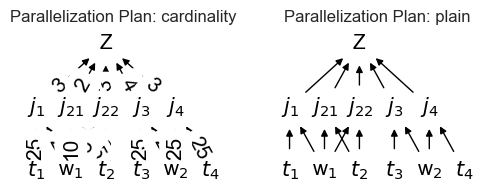

In [97]:
fig_size = (6, 2)
fig, axs = plt.subplots(1, 2, figsize=fig_size)
node_labels_join = {19:r"$j_1$", 20:r"$j_{22}$", 21:r"$j_{21}$", 22:r"$j_3$", 23:r"$j_4$"}
#fdp, neato, tred, gc, gvcolor, circo, patchwork, dot, sccmap, unflatten, sfdp, twopi, nop, acyclic, gvpr, osage, ccomps
label_pos = 0.3
for i_ax, edge_type in enumerate(["cardinality", "plain"]):  #enumerate(["distance", "cardinality", "plain"]):
    # Draw the graph
    pos = nx.nx_agraph.graphviz_layout(rep_plan_nova, prog="dot", args="-Grankdir=BT")
    nx.draw(rep_plan_nova, pos, ax=axs[i_ax], with_labels=False, arrows=True, node_color='none', #edgecolors='black',
            node_size=1000)

    # Extract and draw node labels
    node_labels = nx.get_node_attributes(rep_plan_nova, 'type')
    node_label_sources = prim_df[prim_df["type"] != "WORKER"]["label"].to_dict()
    node_labels.update(node_label_sources)
    node_labels.update(node_labels_join)
    nx.draw_networkx_labels(rep_plan_nova, pos, ax=axs[i_ax], labels=node_labels, font_size=font_size_plot)

    # Extract and draw edge labels based on edge attributes
    if edge_type != "plain":
        edge_labels = nx.get_edge_attributes(rep_plan_nova,
                                             edge_type)  # Replace 'attribute_name' with your edge attribute key
        #rounding due to selectivity
        edge_labels = {key: round(value) for key, value in edge_labels.items()}
        el_in = {k: v for k, v in edge_labels.items() if k[1] != 0}
        el_out = {k: v for k, v in edge_labels.items() if k[1] == 0}
        nx.draw_networkx_edge_labels(rep_plan_nova, pos, ax=axs[i_ax], edge_labels=el_in, label_pos=label_pos,
                                     font_size=font_size_plot)
        nx.draw_networkx_edge_labels(rep_plan_nova, pos, ax=axs[i_ax], edge_labels=el_out, label_pos=label_pos,
                                     font_size=font_size_plot)
    axs[i_ax].set_title("Parallelization Plan: " + edge_type)

    # for saving to svg
    fig_svg, axs_svg = plt.subplots(1, 1, figsize=(fig_size[0] / 2, fig_size[1]))
    nx.draw(rep_plan_nova, pos, ax=axs_svg, with_labels=False, arrows=True, node_color='none', #edgecolors='black',
            node_size=1000)
    nx.draw_networkx_labels(rep_plan_nova, pos, ax=axs_svg, labels=node_labels, font_size=font_size_plot)
    if edge_type != "plain":
        nx.draw_networkx_edge_labels(rep_plan_nova, pos, ax=axs_svg, edge_labels=edge_labels, label_pos=label_pos,
                                     font_size=font_size_plot)
    fig_svg.savefig(
        f"plots/sim/sim_{device_number}/sim_{device_number}_logical_plan_final_{edge_type}_{source_frac}.svg",
        bbox_inches="tight", format="svg")
    plt.close(fig_svg)  # Close the new figure to avoid memory issues

# Show the plot
plt.show()

#### Placement

In [98]:
text_joins = {
    19: {"s": r"j$_{1}$", "ha": "right", "va":"bottom"},
    20: {"s": r"j$_{2}$", "ha": "left", "va":"top"},
    21: {"s": "", "ha": "left", "va":"bottom"},
    22: {"s": r"j$_{4}$", "ha": "right", "va":"top"},
    23: {"s": r"j$_{5}$", "ha": "right", "va":"top"},
}

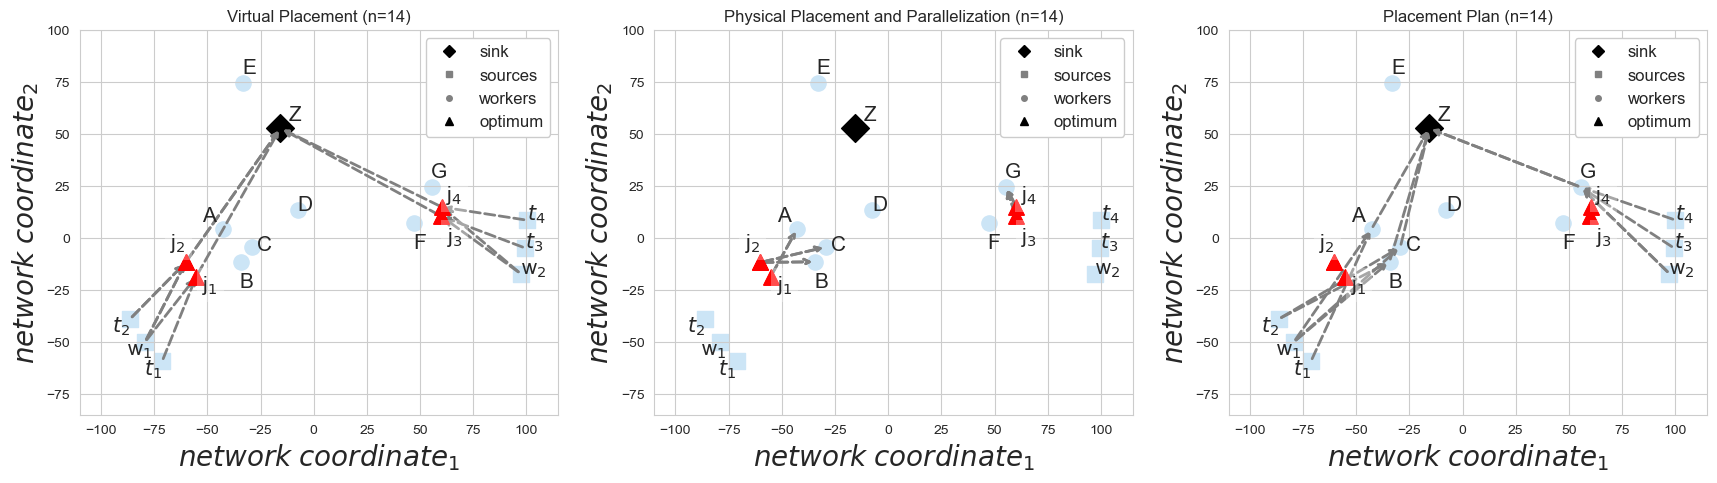

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
ax1, ax2, ax3 = axs
df_nova["cluster"] = 0
add_arrow_labels = False

# resolve the placement
placement_coords = dict()
for key, val in placement_nova.items():
    placement_coords[key] = df_nova.loc[val, coord_cols].to_numpy()

ax1 = util.plot_topology(ax1, df_nova, colors=colors, scale_fac=scale_fac_plot, plot_voronoi=False, plot_centroid=False)
ax2 = util.plot_topology(ax2, df_nova, colors=colors, scale_fac=scale_fac_plot, plot_voronoi=False, plot_centroid=False)
ax3 = util.plot_topology(ax3, df_nova, colors=colors, scale_fac=scale_fac_plot, plot_voronoi=False, plot_centroid=False)

for n1, n2 in rep_plan_nova.edges:
    if n2 not in df_nova.index:
        # plot the logical nodes
        ax1.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=120, color="red", marker="^", zorder=20)
        ax2.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=120, color="red", marker="^", zorder=20)
        ax3.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=120, color="red", marker="^", zorder=20)

        # plot the physical nodes
        #ax2.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)
        #ax3.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)

    if n2 in df_nova.index:
        # virtual node -> sink
        arrow = FancyArrowPatch(rel_positions_nova[n1], rel_positions_nova[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color="grey", linewidth=lw)
        ax1.add_patch(arrow)
        # join to the sink
        arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color="grey", linewidth=lw)
        ax3.add_patch(arrow)
        continue
    else:
        color = "grey"
        # physical nodes -> virtual nodes
        arrow = FancyArrowPatch(rel_positions_nova[n1], rel_positions_nova[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=lw)
        ax1.add_patch(arrow)
        if add_arrow_labels:
            add_arrow_label(ax1, arrow, source_rates[n1], align_with_angle=False)
        #arrow = FancyArrowPatch(rel_positions_nova[n1], rel_positions_nova[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color=color, linewidth=1)
        #ax2.add_patch(arrow)
        # virtual node -> physical node
        arrow = FancyArrowPatch(rel_positions_nova[n2], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=lw)
        ax2.add_patch(arrow)

        arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=lw)
        ax3.add_patch(arrow)
        dist = util.euclidean_distance(placement_coords[n1], placement_coords[n2])
        x_offset = -1.3
        if n1 == 2:
            x_offset += 2.5
        if dist < 25:
            lp = 0.9
        else:
            lp = 0.85
        if add_arrow_labels:
            add_arrow_label(ax3, arrow, rep_plan_nova.get_edge_data(n1, n2).get('cardinality'), align_with_angle=False,
                            va="top", ha="left", label_pos=lp, x_offset=x_offset)

    #arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color="grey", linewidth=1)
    #ax3.add_patch(arrow)

# Add labels next to each point
text_joins = [
    {"x": -55+10, "y": -18-10, "s": r"j$_{1}$", "ha": "right", "va":"bottom"},
    {"x": -55-5, "y": -18+10, "s": r"j$_{2}$", "ha": "right", "va":"bottom"},
    {"x": 60+10, "y": 10-15, "s": r"j$_{3}$", "ha": "right", "va":"bottom"},
    {"x": 60+10, "y": 10+5, "s": r"j$_{4}$", "ha": "right", "va":"bottom"},
]
for ax in axs:
    for join_label in text_joins:
        ax.text(**join_label, bbox=dict(facecolor='white', edgecolor='none', alpha=0.3), fontsize=font_size_plot, zorder=22)
    for i in range(0, prim_df.shape[0]):
        x, y = prim_df.loc[i, coord_cols].to_numpy()
        s_label = prim_df.loc[i, "label"]
        x, y = get_label_pos(s_label, x, y)
        ax.text(x, y, s_label, fontsize=font_size_plot, ha='left')

handles = [coordinator_label, source_label, worker_label, log_opt_label]

for ax in axs:
    ax.legend(handles=handles, loc="upper right", prop={'size': font_size_legend}, framealpha=1)

#ax1.get_legend().remove()
#ax2.get_legend().remove()

for ax in axs:
    ax.set_xlim(X_dim_plot)
    ax.set_ylim(Y_dim_plot)

# Saving: Hide other axes temporarily when saving
for i_ax, ax in enumerate(axs):
    for j_ax, ax in enumerate(axs):
        if i_ax != j_ax:
            ax.set_visible(False)  # Hide the other axis
    fig.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_nova_complete_{i_ax}.svg", bbox_inches="tight")
    for j_ax, ax in enumerate(axs):
        if i_ax != j_ax:
            ax.set_visible(True)  # Restore visibility of the other axis

ax1.set_title('Virtual Placement (n=' + str(prim_df.shape[0]) + ")")
ax2.set_title('Physical Placement and Parallelization (n=' + str(prim_df.shape[0]) + ")", )
ax3.set_title('Placement Plan (n=' + str(prim_df.shape[0]) + ")")
plt.show()